# **네이버 영화 리뷰 감성 분석**  
#### 0. 데이터 정보
#### 1. 데이터 준비와 확인  
#### 2. 데이터로더 구성   
#### 3. 모델 구성을 위한 데이터 분석 및 가공  
#### 4. 모델 구성 및 validation set 구성  
#### 5. 모델 훈련 개시  
#### 6. Loss, Accuracy 그래프 시각화  
#### 7. 학습된 Embedding 레이어 분석  
#### 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

----

### **0.데이터 정보**
https://github.com/e9t/nsmc

**[DATA DESCRIPTION]**  
- [columns]
    - id  
    - document : The actual review  
    - label : The sentiment class of the review (0 : negative, 1: positive)  
        



- Columns are delimited w/ tabs   
  


- rating_test.txt : 50,000 reviews held out for testing  
- rating_train.txt : 150,000 reviews for training  
  


  
**[CHARACTERISTICS]**  
- All reviews are shorter than 140 characters   
- Each sentiment class is sampled equally (i.e., random guess yields 50% accuracy)
    - 100K negative reviews (originally reviews of ratings 1-4)  
    - 100K positive reviews (originally reviews of ratings 9-10)  
    - Neutral reviews (originally reviews of ratings 5-8) are excluded  


----

In [1]:
import pandas as pd
import tensorflow as tf
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import os
from tensorflow import keras

import konlpy
import gensim
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant
from gensim.models.keyedvectors import Word2VecKeyedVectors


print(konlpy.__version__)
print(gensim.__version__)

0.5.2
4.1.2


### **1. 데이터 준비와 확인**

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


----

### **2. 데이터로더 구성**

**[달성 목표]**
- 데이터의 중복 제거  
- NaN 결측치 제거  
- 한국어 토크나이저로 토큰화  
- 불용어(Stopwords) 제거  
- 사전word_to_index 구성  
- 텍스트 스트링을 사전 인덱스 스트링으로 변환  
- X_train, y_train, X_test, y_test, word_to_index 리턴  

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # NaN 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 
    
    # train/test data 리스트 생성
    X_train = []
    X_test = []
    
    # train/test data 토큰화 및 불용어(stopwords) 제거
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환   
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    #return X_train, y_train, X_test, y_test, word_to_index
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}


In [5]:
# 1개 문장, 사전 -> 단어 인덱스 리스트
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# n개 문장 리스트를 -> 단어 인덱스 리스트 벡터 (encode)
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장 -> decode
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# n개의 숫자 벡터로 encode된 문장 -> decode
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

----

### **3. 모델 구성을 위한 데이터 분석 및 가공**

- 데이터셋 내 문장 길이 분포  
- 적절한 최대 문장 길이 지정  
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가  : rnn은 padding 방식을 문장 앞쪽('pre')로 하는 것이 유리함

In [6]:
# 텍스트 데이터 문장 리스트 생성
total_data_text = list(x_train) + list(x_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이 평균값, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이==(평균 + 2*표준편차)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print('pre:' ,x_train.shape)

pre: (146182, 41)


----

### **4. 모델 구성 및 validation set 구성**

- 사용 모델 : RNN, 1-D CNN, GlobalMaxPooling1D

In [8]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [9]:
# RNN
rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
rnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 1-D CNN
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(5))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [11]:
# GlobalMaxPooling1D
gloMP_model = tf.keras.Sequential()
gloMP_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gloMP_model.add(tf.keras.layers.GlobalMaxPooling1D())
gloMP_model.add(tf.keras.layers.Dense(8, activation='relu'))
gloMP_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gloMP_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [12]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


----

### **5. 모델 훈련**

In [13]:
epochs=20  

# RNN
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_history = rnn_model.fit(partial_x_train, partial_y_train, epochs=epochs,
                    batch_size=512, validation_data=(x_val, y_val), verbose=1)
# 1D-CNN
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(partial_x_train, partial_y_train, epochs=epochs,
                    batch_size=512, validation_data=(x_val, y_val), verbose=1)
# GlobalMaxPooling1D
gloMP_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gloMP_history = gloMP_model.fit(partial_x_train, partial_y_train, epochs=epochs,
                    batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 7ms/step - loss: 0.4838 - accuracy: 0.7898 - val_loss: 0.3593 - val_accuracy: 0.8472
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3397 - accuracy: 0.8572 - val_loss: 0.3406 - val_accuracy: 0.8520
Epoch 3/20
266/266 [==============================] - 1s 6ms/step - loss: 0.3188 - accuracy: 0.8678 - val_loss: 0.3394 - val_accuracy: 0.8523
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3073 - accuracy: 0.8728 - val_loss: 0.3444 - val_accuracy: 0.8537
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2989 - accuracy: 0.8766 - val_loss: 0.3426 - val_accuracy: 0.8496
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2902 - accuracy: 0.8804 - val_loss: 0.3452 - val_accuracy: 0.8518
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2819 - accuracy: 0.8841 - val_loss: 0.3439 - val_accuracy: 0.8542
Epoch 

266/266 [==============================] - 1s 3ms/step - loss: 0.1595 - accuracy: 0.9419 - val_loss: 0.4904 - val_accuracy: 0.8311
Epoch 19/20
266/266 [==============================] - 1s 3ms/step - loss: 0.1549 - accuracy: 0.9443 - val_loss: 0.5010 - val_accuracy: 0.8278
Epoch 20/20
266/266 [==============================] - 1s 3ms/step - loss: 0.1507 - accuracy: 0.9463 - val_loss: 0.5159 - val_accuracy: 0.8280


In [14]:
# 테스트셋으로 평가
rnn_results = rnn_model.evaluate(x_test,  y_test, verbose=2)
cnn_results = cnn_model.evaluate(x_test,  y_test, verbose=2)
gloMP_results = gloMP_model.evaluate(x_test,  y_test, verbose=2)

print('='*70)
print('TEST SET 평가 결과')
print('RNN : ', rnn_results)
print('1-D CNN : ', cnn_results)
print('GlobalMaxPooling1D : ', gloMP_results)
print('='*70)


1537/1537 - 3s - loss: 0.4761 - accuracy: 0.8441
1537/1537 - 2s - loss: 0.9720 - accuracy: 0.8143
1537/1537 - 2s - loss: 0.5318 - accuracy: 0.8226
TEST SET 평가 결과
RNN :  [0.4760758578777313, 0.8440710306167603]
1-D CNN :  [0.9719605445861816, 0.8143499493598938]
GlobalMaxPooling1D :  [0.5317578911781311, 0.8226295113563538]


----

### **6. Loss, Accuracy 그래프 시각화**

In [15]:
rnn_history_dict = rnn_history.history
cnn_history_dict = cnn_history.history
gloMP_history_dict = gloMP_history.history

In [16]:
# RNN
rnn_acc = rnn_history_dict['accuracy']
rnn_val_acc = rnn_history_dict['val_accuracy']
rnn_loss = rnn_history_dict['loss']
rnn_val_loss = rnn_history_dict['val_loss']
# 1-D CNN
cnn_acc = cnn_history_dict['accuracy']
cnn_val_acc = cnn_history_dict['val_accuracy']
cnn_loss = cnn_history_dict['loss']
cnn_val_loss = cnn_history_dict['val_loss']
# GlobalMaxPooling1D
gloMP_acc = gloMP_history_dict['accuracy']
gloMP_val_acc = gloMP_history_dict['val_accuracy']
gloMP_loss = gloMP_history_dict['loss']
gloMP_val_loss = gloMP_history_dict['val_loss']

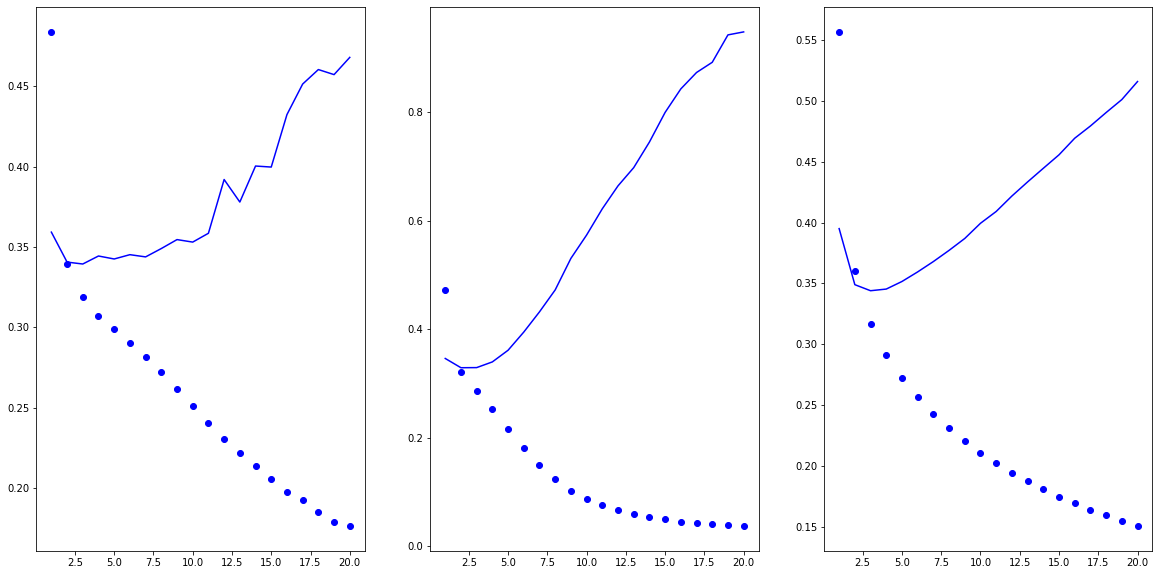

In [17]:
# Training and validation loss
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# RNN
rnn_epochs = range(1, len(rnn_acc) + 1)
ax[0].plot(rnn_epochs, rnn_loss, 'bo', label='RNN Training loss')
ax[0].plot(rnn_epochs, rnn_val_loss, 'b', label='RNN Validation loss')
# 1-D CNN
cnn_epochs = range(1, len(rnn_acc) + 1)
ax[1].plot(cnn_epochs, cnn_loss, 'bo', label='CNN Training loss')
ax[1].plot(cnn_epochs, cnn_val_loss, 'b', label='CNN Validation loss')
# GlobalMaxPooling1D
gloMP_epochs = range(1, len(rnn_acc) + 1)
ax[2].plot(gloMP_epochs, gloMP_loss, 'bo', label='GloMP Training loss')
ax[2].plot(gloMP_epochs, gloMP_val_loss, 'b', label='GloMP Validation loss')



plt.show()

<Figure size 432x288 with 0 Axes>

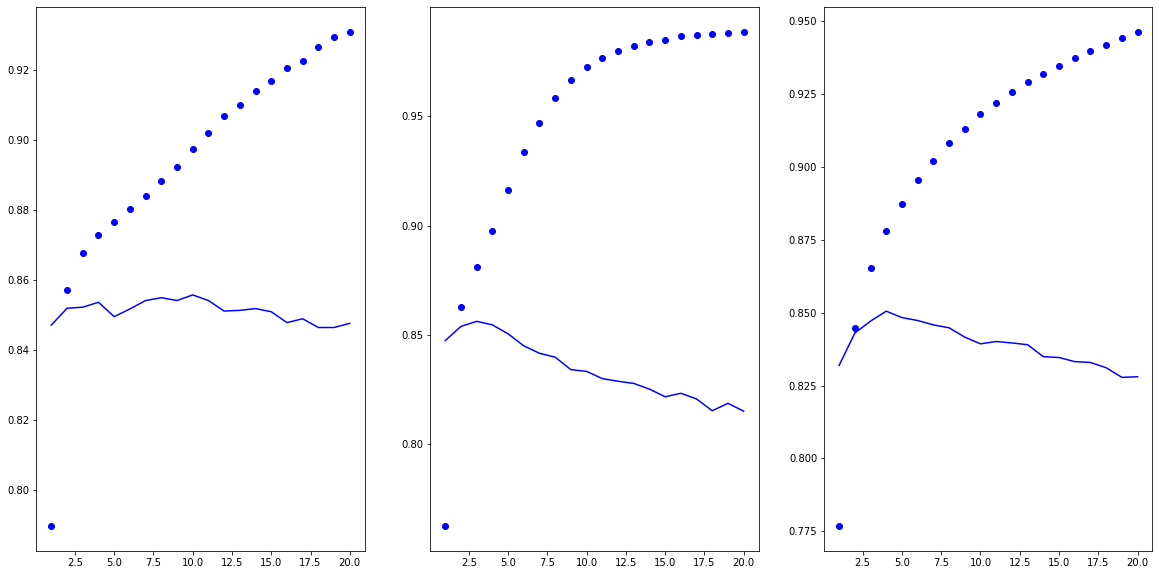

In [18]:
# Training and validation accuracy
# 그림 초기화
plt.clf()   
# Training and validation loss
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# RNN
ax[0].plot(rnn_epochs, rnn_acc, 'bo', label='RNN Training acc')
ax[0].plot(rnn_epochs, rnn_val_acc, 'b', label='RNN Validation acc')
# 1-D CNN
ax[1].plot(cnn_epochs, cnn_acc, 'bo', label='CNN Training acc')
ax[1].plot(cnn_epochs, cnn_val_acc, 'b', label='CNN Validation acc')
# GlobalMaxPooling1D
ax[2].plot(gloMP_epochs, gloMP_acc, 'bo', label='GloMP Training acc')
ax[2].plot(gloMP_epochs, gloMP_val_acc, 'b', label='GloMP Validation acc')

plt.show()

----

### **7. 학습된 Embedding 레이어 분석**

- 가장 성능이 좋은 rnn으로 진행

In [19]:
model = rnn_model
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [20]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ex04.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [21]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['끝']
vector

array([ 0.03237396, -0.01844748, -0.09523553,  0.03759649, -0.00939438,
       -0.00120829, -0.11908659,  0.00809283, -0.03036767, -0.1330717 ,
       -0.00638594, -0.05181484,  0.02072423, -0.00288661, -0.04618519,
       -0.03946176], dtype=float32)

In [22]:
word_vectors.similar_by_word("끝")

[('코스프레', 0.9036999344825745),
 ('it', 0.8994593620300293),
 ('날려', 0.8867150545120239),
 ('팝콘', 0.885641872882843),
 ('..;;', 0.87858647108078),
 ('오글거리', 0.8765516877174377),
 ('66', 0.8723585605621338),
 ('게임', 0.8712698817253113),
 ('자니', 0.8712096810340881),
 ('음침', 0.8711715936660767)]

----

### **8.한국어 Word2Vec 임베딩 활용하여 성능 개선**

- 한국어 Word2Vec은 word2vec_ko.model을 활용
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.  

In [23]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = gensim.models.Word2Vec.load(word2vec_file_path)

In [24]:
word2vec.wv.similar_by_word("끝")


[('마지막', 0.6325399875640869),
 ('결판', 0.5526015758514404),
 ('발목', 0.5465342402458191),
 ('산산조각', 0.5418900847434998),
 ('막바지', 0.5412753820419312),
 ('싫증', 0.5256820917129517),
 ('양쪽', 0.5253474116325378),
 ('무릎', 0.5246764421463013),
 ('후', 0.5051813721656799),
 ('이어진', 0.5038793087005615)]

In [25]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [26]:

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   #trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [27]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 4s 12ms/step - loss: 0.4610 - accuracy: 0.7773 - val_loss: 0.3753 - val_accuracy: 0.8333
Epoch 2/10
266/266 [==============================] - 3s 10ms/step - loss: 0.3434 - accuracy: 0.8490 - val_loss: 0.3372 - val_accuracy: 0.8526
Epoch 3/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2964 - accuracy: 0.8730 - val_loss: 0.3198 - val_accuracy: 0.8601
Epoch 4/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2663 - accuracy: 0.8881 - val_loss: 0.3183 - val_accuracy: 0.8667
Epoch 5/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2409 - accuracy: 0.9015 - val_loss: 0.3141 - val_accuracy: 0.8674
Epoch 6/10
266/266 [==============================] - 3s 10ms/step - loss: 0.2191 - accuracy: 0.9115 - val_loss: 0.3250 - val_accuracy: 0.8648
Epoch 7/10
266/266 [==============================] - 3s 10ms/step - loss: 0.1971 - accuracy: 0.9215 - val_loss: 0.3349 - val_accuracy: 0.8627

In [28]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4026 - accuracy: 0.8587
[0.4025503098964691, 0.8586976528167725]


### **성능개선 결과(RNN)**  
TEST SET 평가 결과  

- loss : 0.4761 -> 0.4026 
- accuracy : 0.8441 -> 0.8587  
  
- #### **loss는 15.44% 감소, accuracy 1.700% 증가**
